In [22]:
# ! pip install tensorflow
# ! pip install imbalanced-learn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import xgboost as xgb
from xgboost import XGBRegressor

from imblearn.over_sampling import SMOTE

import pickle

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = r'D:\Projects\Mini_Projects\Clickstream_customer_conversion\Research_Data\processed_data.csv'

In [3]:
data = pd.read_csv(file_path)
data.head()

,month,day,country,page1_main_category,colour,location,model_photography,page,avg_price,unique_products,browsing_depth,weekend,high_price_preference
0,6,22,29,3,13,1,2,2,46.928571,55,4,1,1
1,5,19,29,2,13,3,1,2,57.666667,4,2,0,1
2,7,15,29,3,9,5,1,1,38.900000,9,3,0,1
3,5,2,29,2,2,4,1,1,51.666667,5,2,0,0
4,6,9,29,2,9,5,1,2,52.333333,12,2,0,1


In [4]:
val = data.drop('high_price_preference', axis = 1)
tar = data['high_price_preference']

In [5]:
fs = XGBRegressor(n_estimators = 200, random_state = 90)

In [6]:
fs.fit(val, tar)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=90, ...)

In [7]:
selected = pd.DataFrame({
    "col": val.columns,
    'sco':fs.feature_importances_
}).sort_values('sco', ascending = False).head(9)['col'].to_list()

In [8]:
val = val[selected]

tar = tar

In [9]:
tar.value_counts()

high_price_preference
0    80230
1    52149
Name: count, dtype: int64

In [10]:
smote = SMOTE()

In [11]:
os_val, os_tar = smote.fit_resample(val, tar)

In [12]:
os_tar.value_counts()

high_price_preference
1    80230
0    80230
Name: count, dtype: int64

In [13]:
x_train, x_test, tr_lab, ts_lab = train_test_split(os_val, os_tar, test_size = 0.2, random_state = 65)

# Logistic Regression

In [14]:

def build_logistic_regression(x_train, x_test, tr_lab, ts_lab):

    print("\n----------Building Logistic Regression----------")

    param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000]
    }

    lr_model = LogisticRegression(random_state=65)

    random_search = RandomizedSearchCV(
        lr_model,
        param_grid,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)

    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title('Logistic Regression Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
            
    return best_model

# Decision Tree

In [15]:
def build_decision_tree(x_train, x_test, tr_lab, ts_lab):

    print("\n----------Building Decision Tree----------")

    param_grid = {
        'max_depth': [None, 5, 10, 15, 20, 30],  
        'min_samples_split': [2, 5, 10, 15],  
        'min_samples_leaf': [1, 2, 4, 6],  
        'criterion': ['gini', 'entropy'],  
        'splitter': ['best', 'random']
    }

    dt_model = DecisionTreeClassifier(random_state=65)

    random_search = RandomizedSearchCV(
        dt_model,
        param_grid,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)
    
    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Decision Tree Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return best_model

# Random Forest

In [16]:

def build_random_forest(x_train, x_test, tr_lab, ts_lab):

    print('\n----------Building Random Forest----------')

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'], 
        'bootstrap': [True, False]
    }

    rf_model = RandomForestClassifier(random_state=65, warm_start=True, n_jobs=-1)

    random_search = RandomizedSearchCV(
        rf_model,
        param_grid,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)
    
    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title('Random Forest Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return best_model

# XG Boost

In [17]:
def build_xgboost(x_train, x_test, tr_lab, ts_lab):

    print('\n----------Building XGBoost----------')

    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],  
        'gamma': [0, 0.1, 0.2], 
        'reg_lambda': [1, 2, 5]
    }

    xgb_model = xgb.XGBClassifier(random_state=65, tree_method="hist", gpu_id=0)

    random_search = RandomizedSearchCV (
        xgb_model,
        param_grid,
        n_iter = 20,  
        cv=3,  
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
    )
    

    random_search.fit(x_train, tr_lab, eval_set=[(x_test, ts_lab)])

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)

    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('XGBoost Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return best_model

# Neural Networks

In [18]:
def build_neural_network(x_train, x_test, tr_lab, ts_lab):

    print("\n----------Building Neural Network----------")

    nn_model = Sequential([
        Dense(100, activation='relu', input_shape = (x_train.shape[1],)),
        Dropout(0.2), 
        Dense(75, activation= 'relu'),
        Dropout(0.2),
        Dense(50, activation='relu'), 
        Dropout(0.2),
        Dense(25, activation='relu'), 
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer = Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = nn_model.fit(x_train, tr_lab,
                        validation_split=0.2,  
                        epochs=50, 
                        batch_size=32,  
                        callbacks=[early_stopping],
                        verbose=1)
    
    ts_pred = (nn_model.predict(x_test) > 0.5).astype(int)

    ts_probs = nn_model.predict(x_test).flatten()

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)

    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title('Neural Network Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return nn_model, history

# Comparing Models

In [19]:
def compare_models(models_dict, x_test, ts_lab):

    print("\n----------Comparing Models----------")

    results = {}

    for name, model in models_dict.items():
        if hasattr(model, "predict"):
            ts_probs = model.predict(x_test)
            ts_pred = (ts_probs > 0.5).astype(int)
        else:
            ts_pred = model.predict(x_test)

        accuracy = accuracy_score(ts_lab, ts_pred)
        auc_score = roc_auc_score(ts_lab, ts_pred)
        results[name] = {
            'Accuracy': accuracy,
            'Roc-Auc Score': auc_score,
            'Predictions': ts_pred
            
        }
    
    comparison = pd.DataFrame(results).T[['Accuracy', 'Roc-Auc Score']]

    comparison = comparison.sort_values('Accuracy', ascending = False)

    print(comparison)

    best_model_name = comparison.index[0]

    best_model = models_dict[best_model_name]

    plt.figure(figsize=(5, 4))
    sns.barplot(x=comparison.index, y='Accuracy', data=comparison)
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return comparison, results, best_model, best_model_name

# Final Call

In [20]:
def run_all_models(x_train, x_test, tr_lab, ts_lab):

    lr_model = build_logistic_regression(x_train, x_test, tr_lab, ts_lab)
    dt_model = build_decision_tree(x_train, x_test, tr_lab, ts_lab)
    rf_model = build_random_forest(x_train, x_test, tr_lab, ts_lab)
    xgb_model = build_xgboost(x_train, x_test, tr_lab, ts_lab)
    nn_model, _ = build_neural_network(x_train, x_test, tr_lab, ts_lab)

    models = {
        'Logistic Regression': lr_model,
        'Decision Tree': dt_model,
        'Random Forest': rf_model,
        'XG Boost': xgb_model,
        'Neural Network': nn_model
    }

    comparison, results, best_model, best_model_name = compare_models(models, x_test, ts_lab)

    pickle_path = r'D:\Projects\Mini_Projects\Clickstream_customer_conversion\Pickles'

    os.makedirs(pickle_path, exist_ok=True)
    
    best_model_class = os.path.join(pickle_path, 'best_model_class.pkl')

    with open(best_model_class, 'wb') as file:
        pickle.dump(best_model, file)

    print(f"\nBest Model for Classification: {best_model_name} saved to 'best_model_class.pkl'")

    return models, comparison, results, best_model, best_model_name


----------Building Logistic Regression----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1000, 'C': 0.1}
Best Cross-Validation Score: 0.6862
Test Accuracy: 0.6867

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68     16048
           1       0.68      0.69      0.69     16044

    accuracy                           0.69     32092
   macro avg       0.69      0.69      0.69     32092
weighted avg       0.69      0.69      0.69     32092



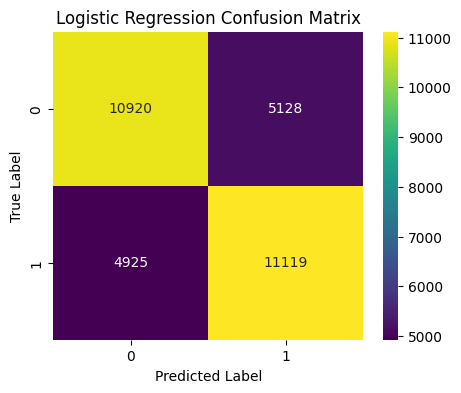

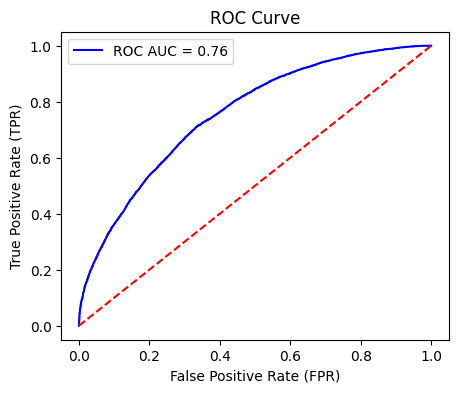


----------Building Decision Tree----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.9369
Test Accuracy: 0.9368

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     16048
           1       0.92      0.95      0.94     16044

    accuracy                           0.94     32092
   macro avg       0.94      0.94      0.94     32092
weighted avg       0.94      0.94      0.94     32092



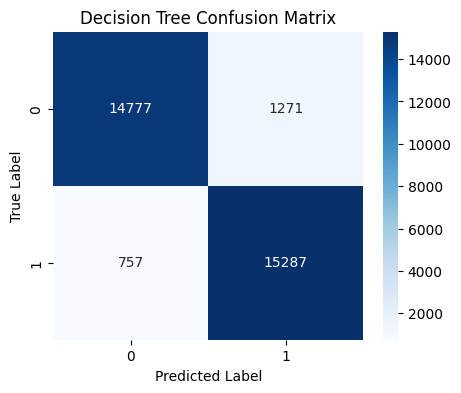

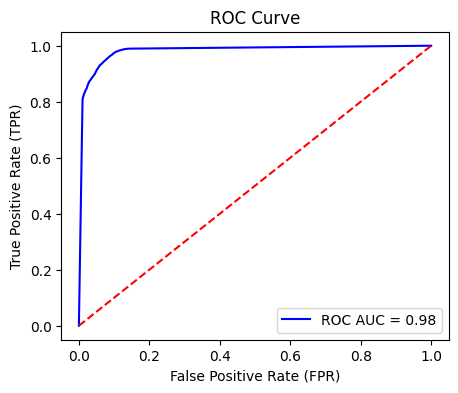


----------Building Random Forest----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}
Best Cross-Validation Score: 0.9417
Test Accuracy: 0.9438

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     16048
           1       0.92      0.97      0.95     16044

    accuracy                           0.94     32092
   macro avg       0.94      0.94      0.94     32092
weighted avg       0.94      0.94      0.94     32092



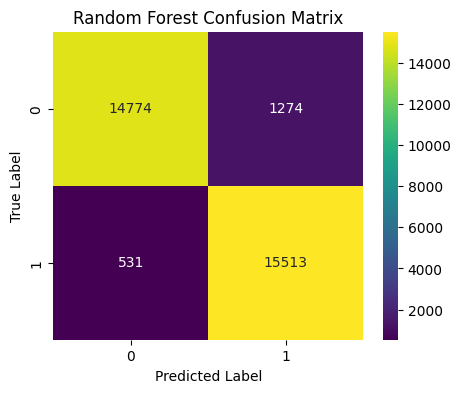

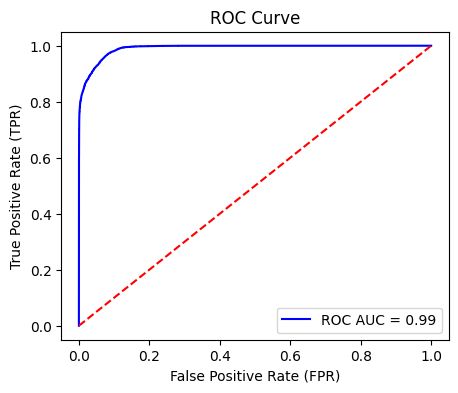


----------Building XGBoost----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[0]	validation_0-logloss:0.63844
[1]	validation_0-logloss:0.57416
[2]	validation_0-logloss:0.49595
[3]	validation_0-logloss:0.46805
[4]	validation_0-logloss:0.44553
[5]	validation_0-logloss:0.43265
[6]	validation_0-logloss:0.39565
[7]	validation_0-logloss:0.37564
[8]	validation_0-logloss:0.36182
[9]	validation_0-logloss:0.35353
[10]	validation_0-logloss:0.34867
[11]	validation_0-logloss:0.33345
[12]	validation_0-logloss:0.31275
[13]	validation_0-logloss:0.29756
[14]	validation_0-logloss:0.28710
[15]	validation_0-logloss:0.27674
[16]	validation_0-logloss:0.26444
[17]	validation_0-logloss:0.25885
[18]	validation_0-logloss:0.24379
[19]	validation_0-logloss:0.24162
[20]	validation_0-logloss:0.24008
[21]	validation_0-logloss:0.23298
[22]	validation_0-logloss:0.23131
[23]	validation_0-logloss:0.22638
[24]	validation_0-logloss:0.22214
[25]	validation_0-logloss:0.22091
[26]	validation_0-logloss:0

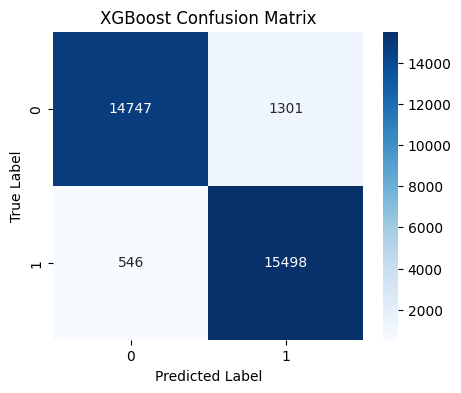

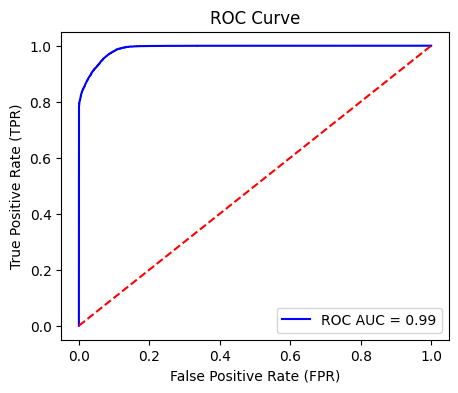


----------Building Neural Network----------
Epoch 1/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.6020 - loss: 0.6759 - val_accuracy: 0.6856 - val_loss: 0.5830
Epoch 2/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6854 - loss: 0.5786 - val_accuracy: 0.7378 - val_loss: 0.5143
Epoch 3/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7209 - loss: 0.5360 - val_accuracy: 0.7818 - val_loss: 0.4556
Epoch 4/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7526 - loss: 0.4892 - val_accuracy: 0.7862 - val_loss: 0.4267
Epoch 5/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7678 - loss: 0.4587 - val_accuracy: 0.8260 - val_loss: 0.3570
Epoch 6/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7850 - loss: 0.4302 - val_accuracy: 0.8322 - val_loss: 0.3459
Epoch 7/50
3210/3210 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7984 - loss: 0.4071 - val_accuracy: 0.8405 - val_loss: 0.3345
Epoch 8/50
3210/3210 ━━━━━━━━━━━━━━━━━

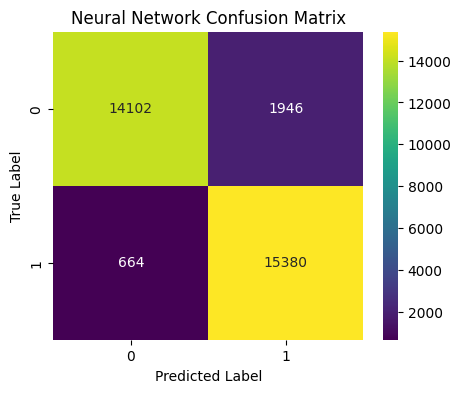

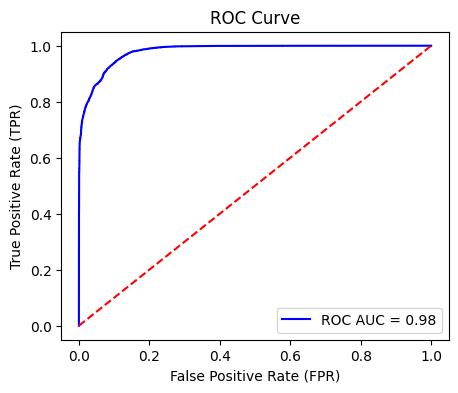


----------Comparing Models----------
1003/1003 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
                     Accuracy Roc-Auc Score
Random Forest        0.943755      0.943758
XG Boost             0.942447       0.94245
Decision Tree        0.936807      0.936809
Neural Network       0.918671      0.918676
Logistic Regression  0.686744      0.686745


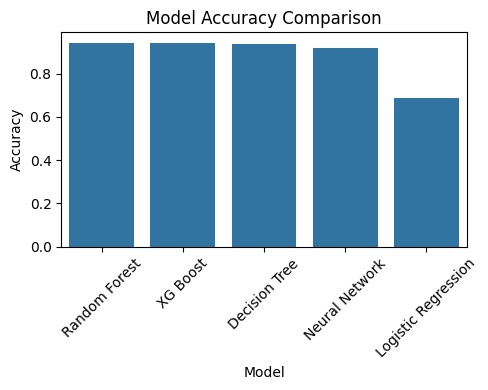


Best Model for Classification: Random Forest saved to 'best_model_class.pkl'


In [21]:
models, comparison, results, best_model, best_model_name = run_all_models(x_train, x_test, tr_lab, ts_lab)